In [22]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_recall_curve 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from plot_metric.functions import BinaryClassification

import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Data reading

In [23]:
pth1 = '/datasets/Churn.csv'
pth2 = 'Churn.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong. Please, check file path.')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Data preprocessing

In [25]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True, axis=1)
df.columns = df.columns.str.lower()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      9091 non-null   int64  
 1   geography        9091 non-null   object 
 2   gender           9091 non-null   object 
 3   age              9091 non-null   int64  
 4   tenure           9091 non-null   float64
 5   balance          9091 non-null   float64
 6   numofproducts    9091 non-null   int64  
 7   hascrcard        9091 non-null   int64  
 8   isactivemember   9091 non-null   int64  
 9   estimatedsalary  9091 non-null   float64
 10  exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 781.4+ KB


### Correlation

<AxesSubplot:>

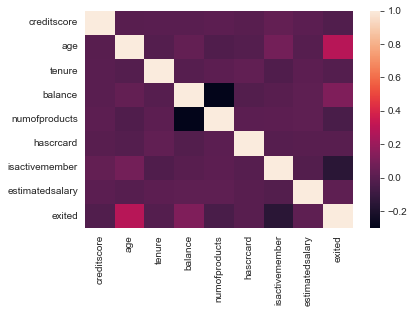

In [27]:
sns.heatmap(df.corr())

### One-hot encoding

In [28]:
df = pd.get_dummies(df, drop_first=True)

In [29]:
df

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9086,800,29,2.0,0.00,2,0,0,167773.55,0,0,0,0
9087,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9088,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9089,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0


### Data splitting

In [30]:
X = df.drop('exited', axis=1)
y = df['exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12345) 

### Data scaling

In [31]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

### Model learning (search for the best model and hyperparameters)

#### LogisticRegression

In [32]:
model = LogisticRegression(class_weight='balanced', random_state=12345, solver='liblinear')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
print('F1-score {:.3f}'.format(f1_score(y_valid, predicted_valid)))
print('Accuracy score {:.3f}'.format(accuracy_score(y_valid, predicted_valid)))

F1-score 0.495
Accuracy score 0.718


In [33]:
auc_roc = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
print('AUC ROC: {:.3f}'.format(auc_roc))

AUC ROC: 0.775


#### RandomForestClassifier

In [34]:
best_F1_result = 0

for est in range(1, 50):
    for depth in range(1, 10):
    
        model = RandomForestClassifier(class_weight='balanced', random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(X_train, y_train)
        predicted_valid = model.predict(X_valid)

        result = accuracy_score(y_valid, predicted_valid)
        F1_score = f1_score(y_valid, predicted_valid)
    
        if F1_score > best_F1_result:
        
            best_F1_result = F1_score
            best_est = est
            best_depth = depth
        
print("Accuracy наилучшей модели на валидационной выборке: {:.3f}".format(result)) 
print("F1-score наилучшей модели на валидационной выборке: {:.3f}".format(F1_score)) 
print("n_estimators наилучшей модели на валидационной выборке:", best_est)
print("max_depth наилучшей модели на валидационной выборке:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.834
F1-score наилучшей модели на валидационной выборке: 0.600
n_estimators наилучшей модели на валидационной выборке: 24
max_depth наилучшей модели на валидационной выборке: 8


In [35]:
auc_roc = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
print('AUC ROC: {:.3f}'.format(auc_roc))

AUC ROC: 0.849


#### DecisionTreeClassifier

In [36]:
best_F1_result = 0

for depth in range(1, 20):
    
    model = DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=depth)
    model.fit(X_train, y_train)    
    predicted_valid = model.predict(X_valid)
    
    result = accuracy_score(y_valid, predicted_valid)
    F1_score = f1_score(y_valid, predicted_valid)
    
    if F1_score > best_F1_result:
        
        best_F1_result = F1_score
        best_depth = depth
        
print("Accuracy наилучшей модели на валидационной выборке: {:.3f}".format(result)) 
print("F1-score наилучшей модели на валидационной выборке: {:.3f}".format(F1_score)) 
print("Best depth наилучшей модели на валидационной выборке:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.789
F1-score наилучшей модели на валидационной выборке: 0.485
Best depth наилучшей модели на валидационной выборке: 7


In [37]:
auc_roc = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
print('AUC ROC: {:.3f}'.format(auc_roc))

AUC ROC: 0.679


### Testing

In [38]:
# model training
model = RandomForestClassifier(class_weight='balanced', random_state=12345, n_estimators=24, max_depth=8)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=24,
                       random_state=12345)

In [39]:
# prediction on X_test
predicted_test = model.predict(X_test)

In [40]:
result = accuracy_score(y_test, predicted_test)
F1_score = f1_score(y_test, predicted_test)
print("Accuracy наилучшей модели на тестовой выборке: {:.3f}".format(result)) 
print("F1-score наилучшей модели на тестовой выборке: {:.3f}".format(F1_score)) 

Accuracy наилучшей модели на тестовой выборке: 0.828
F1-score наилучшей модели на тестовой выборке: 0.615


In [41]:
auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print('AUC ROC: {:.3f}'.format(auc_roc))

AUC ROC: 0.858


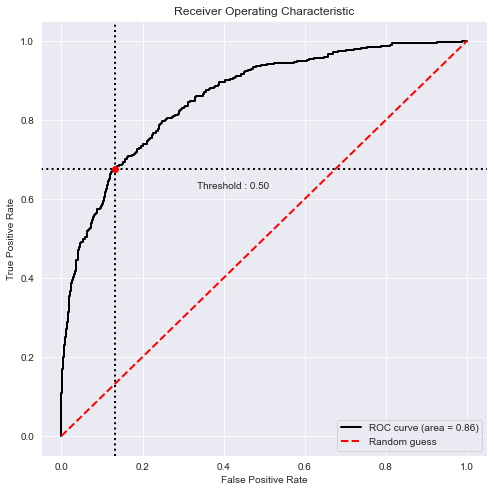

                       Roc Auc Score is: 0.858




In [42]:
y_pred = model.predict_proba(X_test)[:,1]
bc = BinaryClassification(y_test, y_pred, labels=["Class 1"])

plt.figure(figsize=(8,8))
bc.plot_roc_curve()
plt.show()
print('                       Roc Auc Score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print('\n')

### Conclusion

Best model: RandomForestClassifier  
Best hyperparameters: n_estimators=24, max_depth=8  
Best F1_score=0.62  
Best accuracy=0.83  
AUC_ROC=0.86